# Thrones2Vec

© Yuriy Guts, 2016

Using only the raw text of [A Song of Ice and Fire](https://en.wikipedia.org/wiki/A_Song_of_Ice_and_Fire), we'll derive and explore the semantic properties of its words.

## Imports

In [1]:
from __future__ import absolute_import, division, print_function

In [2]:
import codecs
import glob
import logging
import multiprocessing
import os
import pprint
import re

In [3]:
import nltk
import gensim.models.word2vec as w2v
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


**Set up logging**

In [5]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

**Download NLTK tokenizer models (only the first time)**

In [6]:
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lucar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lucar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Prepare Corpus

**Load books from files**

In [7]:
book_filenames = sorted(glob.glob("data/*.txt"))

In [8]:
print("Found books:")
book_filenames

Found books:


['data\\got1.txt',
 'data\\got2.txt',
 'data\\got3.txt',
 'data\\got4.txt',
 'data\\got5.txt']

**Combine the books into one string**

In [9]:
corpus_raw = u""
for book_filename in book_filenames:
    print("Reading '{0}'...".format(book_filename))
    with codecs.open(book_filename, "r", "utf-8") as book_file:
        corpus_raw += book_file.read()
    print("Corpus is now {0} characters long".format(len(corpus_raw)))
    print()

Reading 'data\got1.txt'...
Corpus is now 1770659 characters long

Reading 'data\got2.txt'...
Corpus is now 4071041 characters long

Reading 'data\got3.txt'...
Corpus is now 6391405 characters long

Reading 'data\got4.txt'...
Corpus is now 8107945 characters long

Reading 'data\got5.txt'...
Corpus is now 9719485 characters long



**Split the corpus into sentences**

In [10]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [11]:
raw_sentences = tokenizer.tokenize(corpus_raw)

In [12]:
#convert into a list of words
#rtemove unnnecessary,, split into words, no hyphens
#list of words
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return words

In [13]:
#sentence where each word is tokenized
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [14]:
print(raw_sentences[5])
print(sentence_to_wordlist(raw_sentences[5]))

Heraldic crest by Virginia Norey.
['Heraldic', 'crest', 'by', 'Virginia', 'Norey']


In [15]:
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens".format(token_count))

The book corpus contains 1,818,103 tokens


## Train Word2Vec

In [16]:
#ONCE we have vectors
#step 3 - build model
#3 main tasks that vectors help with
#DISTANCE, SIMILARITY, RANKING

# Dimensionality of the resulting word vectors.
#more dimensions, more computationally expensive to train
#but also more accurate
#more dimensions = more generalized
num_features = 200
#num_features = 300
# Minimum word count threshold.
min_word_count = 3

# Number of threads to run in parallel.
#more workers, faster we train
num_workers = multiprocessing.cpu_count()

# Context window length.
context_size = 5
#context_size = 7

# Downsample setting for frequent words.
#0 - 1e-5 is good for this
downsampling = 1e-3

# Seed for the RNG, to make the results reproducible.
#random number generator
#deterministic, good for debugging
seed = 1

In [17]:
thrones2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [18]:
thrones2vec.build_vocab(sentences)

2019-10-22 00:17:12,012 : INFO : collecting all words and their counts
2019-10-22 00:17:12,013 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-10-22 00:17:12,038 : INFO : PROGRESS: at sentence #10000, processed 140984 words, keeping 10280 word types
2019-10-22 00:17:12,062 : INFO : PROGRESS: at sentence #20000, processed 279730 words, keeping 13558 word types
2019-10-22 00:17:12,085 : INFO : PROGRESS: at sentence #30000, processed 420336 words, keeping 16598 word types
2019-10-22 00:17:12,111 : INFO : PROGRESS: at sentence #40000, processed 556581 words, keeping 18324 word types
2019-10-22 00:17:12,133 : INFO : PROGRESS: at sentence #50000, processed 686247 words, keeping 19714 word types
2019-10-22 00:17:12,161 : INFO : PROGRESS: at sentence #60000, processed 828497 words, keeping 21672 word types
2019-10-22 00:17:12,188 : INFO : PROGRESS: at sentence #70000, processed 973830 words, keeping 23093 word types
2019-10-22 00:17:12,218 : INFO : PROGRESS: at 

In [71]:
print("Word2Vec vocabulary length:", len(thrones2vec.wv.vocab))
#print("Word2Vec vocabulary length:", len(thrones2vec.vocab))

Word2Vec vocabulary length: 17277
Word2Vec vocabulary length: 17277


**Start training, this might take a minute or two...**

In [20]:
thrones2vec.train(sentences, total_words=thrones2vec.corpus_total_words, epochs=11)
#thrones2vec.train(sentences)

2019-10-22 00:17:12,646 : INFO : training model with 12 workers on 17277 vocabulary and 200 features, using sg=1 hs=0 sample=0.001 negative=5 window=5
2019-10-22 00:17:13,662 : INFO : EPOCH 1 - PROGRESS: at 58.76% words, 822918 words/s, in_qsize 23, out_qsize 0
2019-10-22 00:17:14,191 : INFO : worker thread finished; awaiting finish of 11 more threads
2019-10-22 00:17:14,196 : INFO : worker thread finished; awaiting finish of 10 more threads
2019-10-22 00:17:14,202 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-10-22 00:17:14,204 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-10-22 00:17:14,228 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-10-22 00:17:14,237 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-10-22 00:17:14,250 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-10-22 00:17:14,251 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-10-

2019-10-22 00:17:23,201 : INFO : EPOCH 7 - PROGRESS: at 58.21% words, 818528 words/s, in_qsize 23, out_qsize 0
2019-10-22 00:17:23,743 : INFO : worker thread finished; awaiting finish of 11 more threads
2019-10-22 00:17:23,759 : INFO : worker thread finished; awaiting finish of 10 more threads
2019-10-22 00:17:23,760 : INFO : worker thread finished; awaiting finish of 9 more threads
2019-10-22 00:17:23,787 : INFO : worker thread finished; awaiting finish of 8 more threads
2019-10-22 00:17:23,796 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-10-22 00:17:23,808 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-10-22 00:17:23,812 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-10-22 00:17:23,816 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-10-22 00:17:23,817 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-10-22 00:17:23,819 : INFO : worker thread finished; awaiting fi

(15448402, 19999133)

**Save to file, can be useful later**

In [21]:
if not os.path.exists("trained"):
    os.makedirs("trained")

In [22]:
thrones2vec.save(os.path.join("trained", "thrones2vec.w2v"))

2019-10-22 00:17:30,203 : INFO : saving Word2Vec object under trained\thrones2vec.w2v, separately None
2019-10-22 00:17:30,204 : INFO : not storing attribute vectors_norm
2019-10-22 00:17:30,206 : INFO : not storing attribute cum_table
2019-10-22 00:17:30,453 : INFO : saved trained\thrones2vec.w2v


## Explore the trained model.

In [23]:
thrones2vec = w2v.Word2Vec.load(os.path.join("trained", "thrones2vec.w2v"))

2019-10-22 00:17:30,458 : INFO : loading Word2Vec object from trained\thrones2vec.w2v
2019-10-22 00:17:30,703 : INFO : loading wv recursively from trained\thrones2vec.w2v.wv.* with mmap=None
2019-10-22 00:17:30,704 : INFO : setting ignored attribute vectors_norm to None
2019-10-22 00:17:30,704 : INFO : loading vocabulary recursively from trained\thrones2vec.w2v.vocabulary.* with mmap=None
2019-10-22 00:17:30,706 : INFO : loading trainables recursively from trained\thrones2vec.w2v.trainables.* with mmap=None
2019-10-22 00:17:30,706 : INFO : setting ignored attribute cum_table to None
2019-10-22 00:17:30,707 : INFO : loaded trained\thrones2vec.w2v


### Compress the word vectors into 2D space and plot them

In [24]:
#my video - how to visualize a dataset easily
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [25]:
all_word_vectors_matrix = thrones2vec.trainables.syn1neg
#all_word_vectors_matrix = thrones2vec.syn0

**Train t-SNE, this could take a minute or two...**

In [26]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

**Plot the big picture**

In [54]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[thrones2vec.wv.vocab[word].index])
            for word in thrones2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [55]:
points.head(10)

,word,x,y
0,This,-12.439946,-16.769281
1,edition,-44.544273,31.148560
2,the,11.308488,12.801117
3,complete,-18.151379,0.622398
4,of,0.310869,10.664516
5,original,-3.982500,-10.281551
6,hardcover,-44.137535,30.656042
7,ONE,-47.027420,20.673573
8,A,9.602784,3.482767
9,OF,-49.114838,27.926304


In [56]:
sns.set_context("poster")

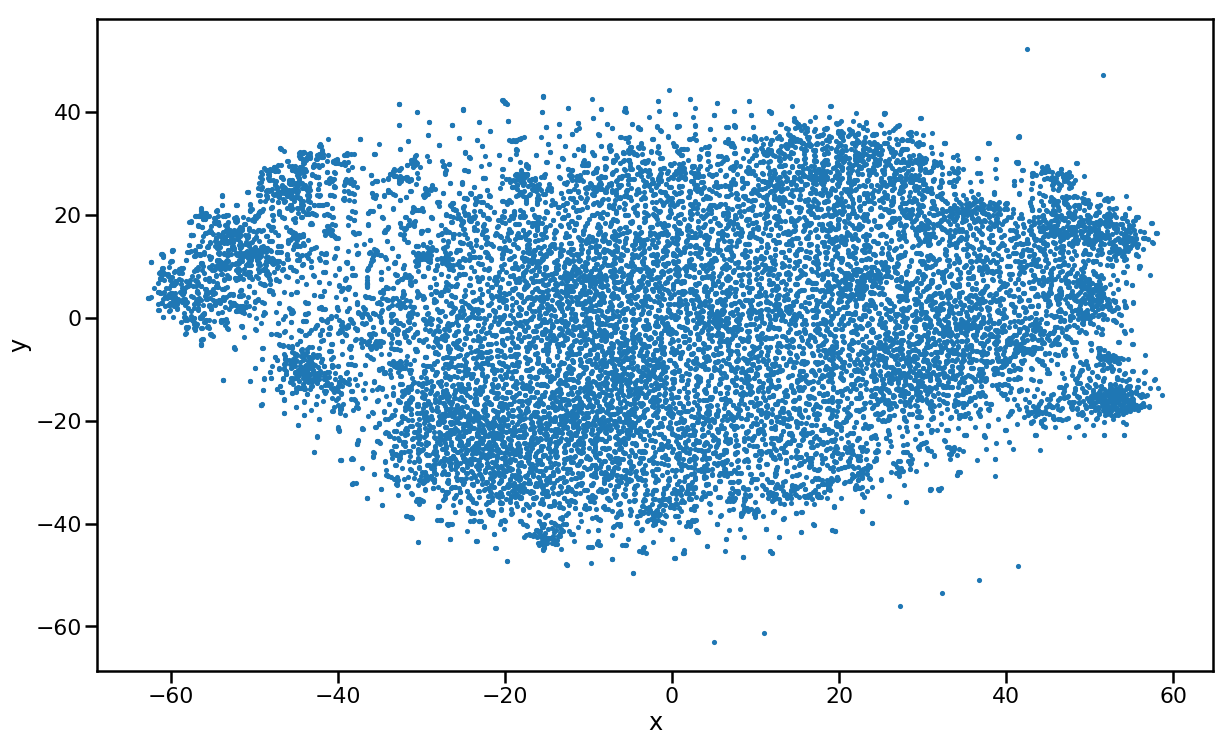

In [57]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

**Zoom in to some interesting places**

In [58]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

**People related to Kingsguard ended up together**

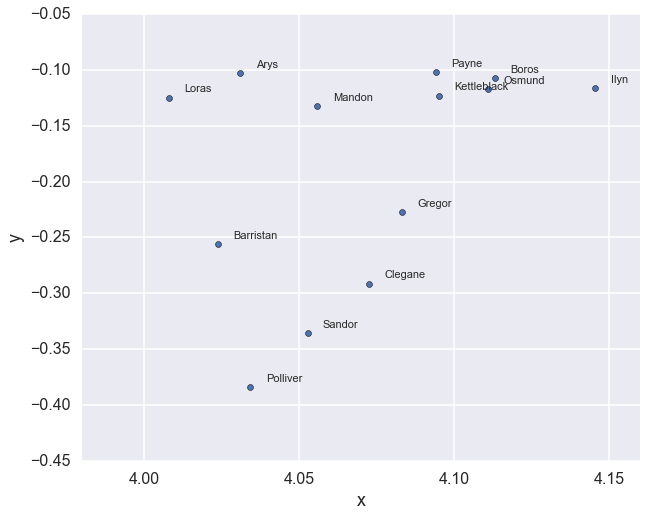

In [32]:
plot_region(x_bounds=(4.0, 4.2), y_bounds=(-0.5, -0.1))

**Food products are grouped nicely as well. Aerys (The Mad King) being close to "roasted" also looks sadly correct**

In [70]:
plot_region(x_bounds=(0, 1), y_bounds=(4, 4.5))

ValueError: scatter requires x column to be numeric

### Explore semantic similarities between book characters

**Words closest to the given word**

In [62]:
thrones2vec.most_similar("Stark")

C:\Users\lucar\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2019-10-22 00:38:56,325 : INFO : precomputing L2-norms of word weight vectors


[('Eddard', 0.6827921867370605),
 ('executed', 0.5495690107345581),
 ('Karstark', 0.5340383648872375),
 ('Robb', 0.5235292315483093),
 ('absently', 0.513822615146637),
 ('Winterfell', 0.5117062926292419),
 ('Edrick', 0.5104243755340576),
 ('beheaded', 0.5104086995124817),
 ('Lyanna', 0.5025713443756104),
 ('boyhood', 0.5009626150131226)]

In [63]:
thrones2vec.most_similar("Aerys")

C:\Users\lucar\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('Jaehaerys', 0.6483460664749146),
 ('II', 0.6374136805534363),
 ('Daeron', 0.6246479749679565),
 ('Conciliator', 0.6022646427154541),
 ('Beggar', 0.5994874238967896),
 ('Maekar', 0.5899921655654907),
 ('Mad', 0.5846443176269531),
 ('Cruel', 0.581684947013855),
 ('Unlikely', 0.5809341669082642),
 ('Unworthy', 0.577689528465271)]

In [64]:
thrones2vec.most_similar("direwolf")

C:\Users\lucar\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('wolf', 0.5801998376846313),
 ('SHAGGYDOG', 0.5285704135894775),
 ('pup', 0.5275605916976929),
 ('GHOST', 0.5124660730361938),
 ('Ghost', 0.5101807117462158),
 ('Rickon', 0.4954892098903656),
 ('muzzle', 0.4872754216194153),
 ('Shaggydog', 0.48648977279663086),
 ('RICKON', 0.48236823081970215),
 ('Stark', 0.4787527322769165)]

**Linear relationships between word pairs**

In [65]:
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = thrones2vec.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

In [66]:
nearest_similarity_cosmul("Stark", "Winterfell", "Riverrun")
nearest_similarity_cosmul("Jaime", "sword", "wine")
nearest_similarity_cosmul("Arya", "Nymeria", "dragons")

Stark is related to Winterfell, as Tully is related to Riverrun
Jaime is related to sword, as hippocras is related to wine
Arya is related to Nymeria, as Brienne is related to dragons


C:\Users\lucar\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `most_similar_cosmul` (Method will be removed in 4.0.0, use self.wv.most_similar_cosmul() instead).
  after removing the cwd from sys.path.


'Brienne'

# Aufgaben Testat Word2Vec

### Wie ähnlich sind sich Jon und Ygritte?

In [76]:
thrones2vec.wv.similarity("Jon","Ygritte")

0.55232704

### Wie sieht der Vektor aus zu Arryn?

In [73]:
thrones2vec.wv.get_vector("Arryn")

array([ 0.18561   ,  0.35875365,  0.2601436 , -0.13405934,  0.3683659 ,
       -0.43380624, -0.11412003,  0.22432289, -0.4464936 ,  0.28248286,
       -0.02522176,  0.16014314,  0.5067796 ,  0.06479654, -0.1785122 ,
        0.36805403, -0.11137998, -0.19977604,  0.03389481, -0.14497769,
        0.13316497,  0.17746145, -0.22390784,  0.24420539, -0.10045806,
        0.37383208,  0.21293247, -0.2590802 , -0.18462643, -0.10966399,
       -0.02974858,  0.12958747,  0.05709292, -0.07694476, -0.24200153,
        0.02696481,  0.38937417, -0.14927085,  0.26068386, -0.23044251,
        0.46072724,  0.16512434, -0.7006726 , -0.32973582, -0.13905676,
        0.42038187,  0.13829844,  0.06291134,  0.33847344, -0.03027559,
        0.01250862, -0.04532741, -0.0675396 ,  0.32865462,  0.49936154,
       -0.06102641,  0.541448  ,  0.24408393,  0.21614273,  0.13983195,
        0.07643694,  0.3672763 ,  0.9518436 ,  0.47976232,  0.63618845,
       -0.16757454,  0.11722561,  0.25673392,  0.17206694,  0.34

### Welche 7 Wörter sind am ähnlichsten zu Lannister?

In [1]:
thrones2vec.wv.("Lannister", topn=7)

SyntaxError: invalid syntax (<ipython-input-1-d63fbd9fde33>, line 1)

### Was ergibt: Stark + Winterfell – Dragons?

In [78]:
thrones2vec.wv.most_similar(positive=['Stark', 'Winterfell'], negative=['Dragons'], topn=1)

[('Eddard', 0.5765367746353149)]

### Was passt nicht „Winterfell, Riverrun, Jaime“?

In [81]:
thrones2vec.wv.doesnt_match('Winterfell Riverrun Jaime'.split())

'Jaime'

### Wie ähnlich sind sich folgende Sätze?

Satz1: „Hodor That was all he ever said“ / 
Satz2: „Hold the door“

In [90]:
satz1 = 'Hodor That was all he ever said'.lower().split()
satz2 = 'Hold the door'.lower().split()
similarity = thrones2vec.wv.wmdistance(satz1, satz2)
print(similarity)

2019-10-22 01:02:04,164 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-10-22 01:02:04,165 : INFO : built Dictionary(10 unique tokens: ['all', 'ever', 'he', 'hodor', 'said']...) from 2 documents (total 10 corpus positions)


4.200335540997195
